![banner](../static/banner.png)

---

# Part 4 - Creating neural networks to classify handwritten digits 🔢✍🏾

- So we're going to create a neural network, but what is it actually going to do?
- Handwritten number recognition on MNIST data set (classical example, "Hello world" of neural networks)
- OCR vs machine learning?? How to tie this task back into the ABS?
- Insert some pretty pictures

## Plan of attack 🎯

- Describe how we're going to use NN to solve the above problem
- E.g. what kind of neural network we're going to use, how many layers, how many hidden nodes etc.
- Conceptual overview of the data and the network so that people don't dive into the code without any understanding of what we're actually doing
- Outline key steps:
    - Prepare our environment (load in required packages)
    - Load in the data and convert it into required format (training and test, transpose etc)
    - Define some simple but useful functions (activation functions, helper functions e.g. shuffle, dot product, one hot encoding etc) (**NOTE**: Participants don't need to understand these, not important)
    - Initialise neural net
    - Feed forward
    - Backpropagation
    - Gradient descent
    - Measuring accuracy and plotting results

## Let's code it up 👩‍💻

### Preparing our coding environment

In [15]:
library(data.table) # To read the csv file quickly
library(ggplot2) # For basic plotting
set.seed(1)

### Helper functions

These functions are used to help make coding and visualising our neural net a little bit easier. **You don't need to understand these** to get the what our neural network is doing, but feel free to take a look if you're curious!

In [16]:
shuffle = function(A) {
  # Shuffles the rows of a matrix
  return(A[sample(nrow(A)), ])
}

one_hot = function(Y) {
  # Converts Y from a list of numbers (categorical variables) to a matrix.
  # In this matrix, each column corresponds to a digit. In each column, all
  # entries are zero except there is a single 1. The row that this 1 is in
  # encodes what number the digit encoded in that column is.
  # For example, a 1 in column 78, row 6 of the matrix would mean that the 78th 
  # digit in Y is a 5 (since row numbers start from 1, but our lowest digit is 0).
  one_hot_Y = matrix(0, length(Y), max(Y) + 1)
  for(i in 1:length(Y)) {
    one_hot_Y[i, Y[i] + 1] = 1
  }
  one_hot_Y = t(one_hot_Y)
  return(one_hot_Y)
}

print_training_progress = function(nn, Y, iteration) {
    # Prints to console some information as the network is being trained
    cat("-*-")
    flush.console()

    if (iteration %% 10 == 0) {
      cat("\n")
      predictions = get_predictions(nn)
      accuracy = get_accuracy(predictions, Y)
      cat(paste0("Iteration: ", iteration, ", Accuracy: ", round(accuracy, 2), "\n"))
      flush.console()
    }
}

plot_activation = function(activation_function, x = seq(-7,7,0.001)) {
    # Used to plot the activation function
    df = data.frame(x = x, y = activation_function(x))
    options(repr.plot.width = 12, repr.plot.height = 5)
    
    ggplot(df, aes(x, y)) +
      geom_line(lwd = 1.5) +
      theme_minimal() +
      theme(text = element_text(size = 20), element_line(size = 1)) +
      ylab(paste0("y = ", deparse(substitute(activation_function)), "(x)"))
}

### Loading in the MNIST data

In [17]:
data = data.table::fread("../data/kaggle-MNIST-train.csv")
data = as.matrix(data)
m = nrow(data)
n = ncol(data)

data = shuffle(data)

data_dev = t(data[1:1000, ])
Y_dev = data_dev[1, ]
X_dev = data_dev[2:n, ]
X_dev = X_dev / 255.

data_train = t(data[1001:m, ])
Y_train = data_train[1, ]
X_train = data_train[2:n, ]
X_train = X_train / 255.

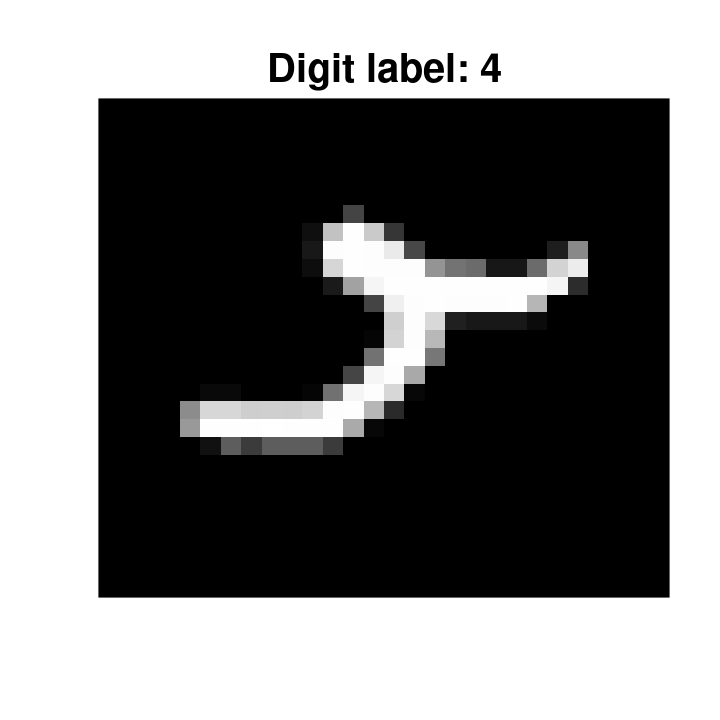

In [111]:
options(repr.plot.width = 6, repr.plot.height = 6)

display_digit = function(digit_index) {
    digit = matrix(X_train[, digit_index], nrow = 28, ncol = 28)
    digit = t(digit)
    image(1:28, 1:28, digit, col=gray((0:255)/255), axes = FALSE, xlab = "", ylab = "")
    # text(x = 3, y = 1, as.character(Y_train[digit_index]), col = "white", cex = 5)
    title(paste0("Digit label: ", as.character(Y_train[digit_index])), col.main = "black", line = 0.7, cex.main = 2)
    #cat(Y_train[digit_index])
}

display_digit(241)

In [105]:
rotate <- function(x) t(apply(x, 2, rev))

In [106]:
digit_index = 1424
digit = matrix(X_train[, digit_index], nrow = 28, ncol = 28)


0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.00000000,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.00000000,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.00000000,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.00000000,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.00000000,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.00000000,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.00000000,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.07843137,0.08235294,0.0000000,0.00000000,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.75294118,0.99215686,0.3568627,0.03921569,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,⋯,0.43921569,0.99607843,0.9921569,0.20000000,0,0,0,0,0,0
0,0,0.0000000,0.0000000,0.0000000,0.0000000,0.03921569,0.5137255,0.5921569,0.9137255,⋯,0.00000000,0.71764706,0.8313725,0.83529412,0,0,0,0,0,0


### Coding the Neural Network

#### Activation functions
Here we define the activation function we'll use in our network (and it's derivative). The function we'll use for our network is a classic, called the ***sigmoid function***.

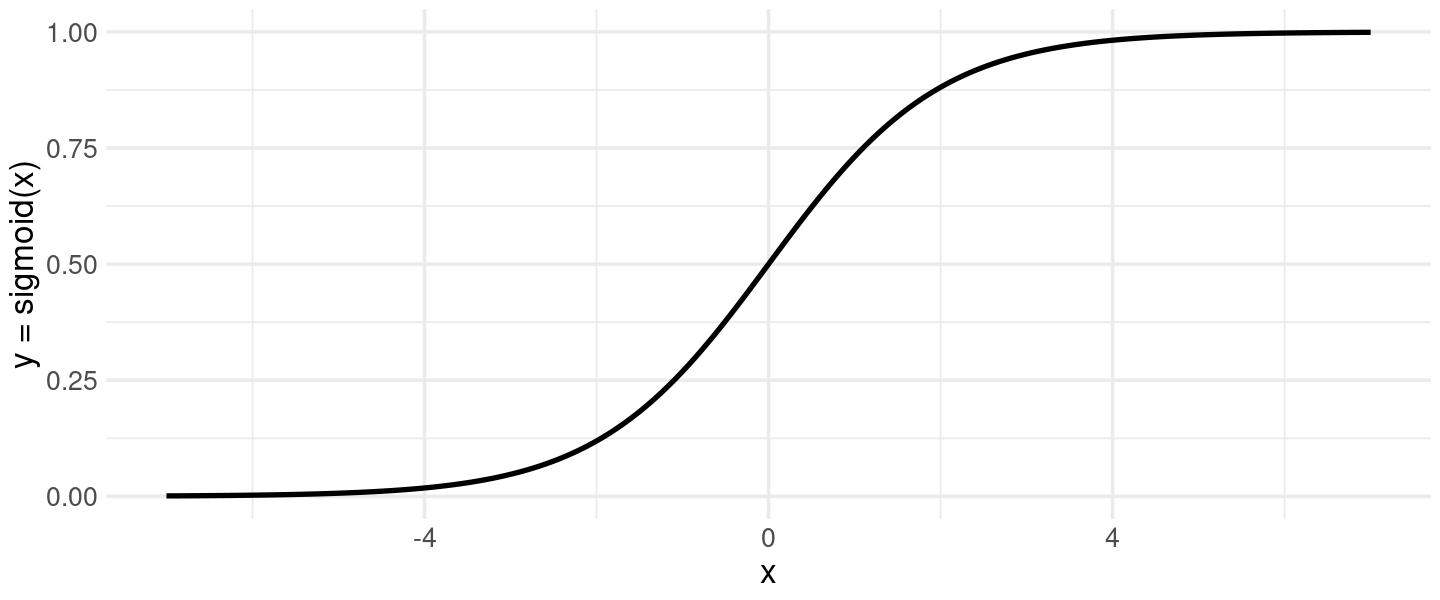

In [4]:
sigmoid = function(Z) {
  # The sigmoid function.
  return(1/(1 + exp(-Z)))
}

sigmoid_derivative = function(Z) {
  # The derivative of the sigmoid function.
  return(sigmoid(Z) * (1 - sigmoid(Z)))
}

plot_activation(sigmoid)

There are a variety of other activation functions that are commonly used. Two such functions are plotted below.

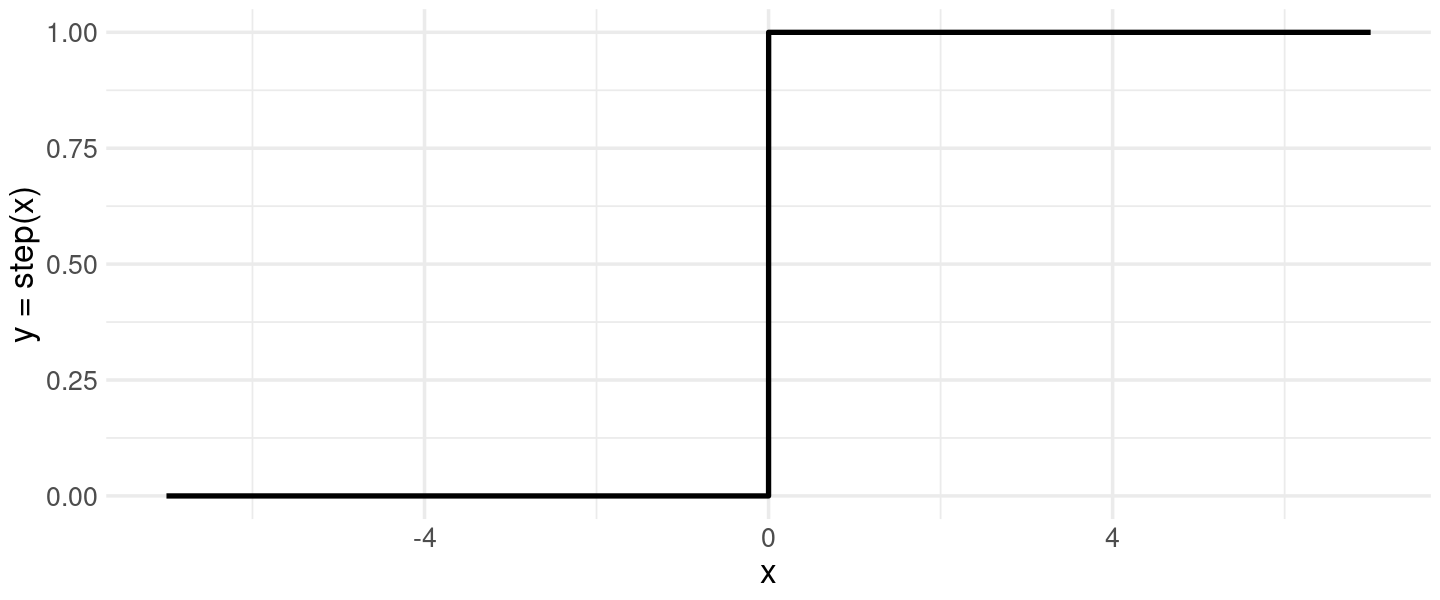

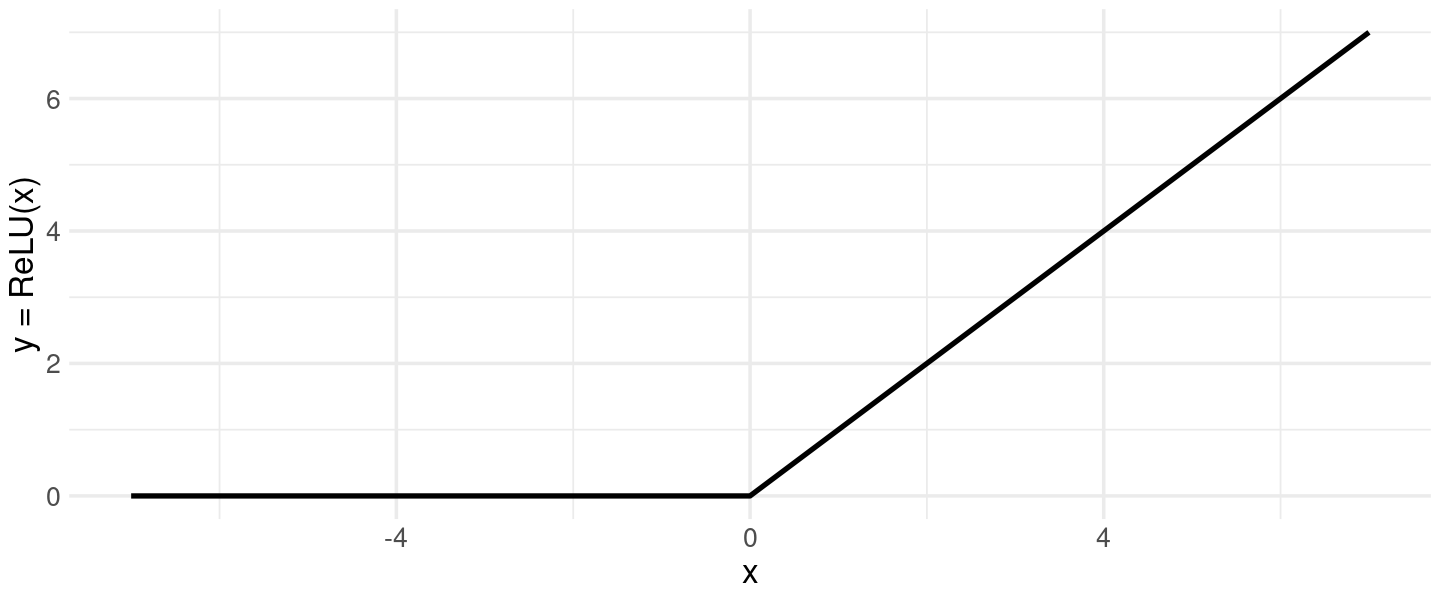

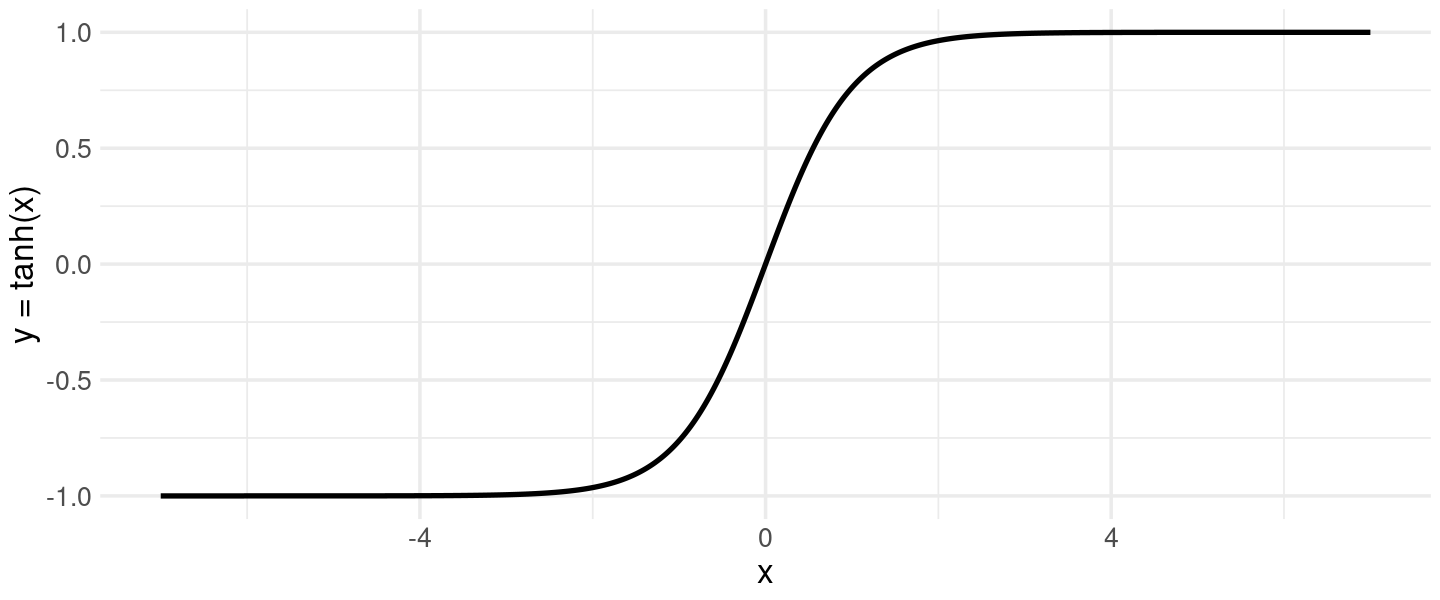

In [5]:
step = function(Z, threshold = 0) {
    return(ifelse(Z > threshold, 1 ,0))
}

ReLU = function(Z) {
  return(pmax(Z,0))
}

plot_activation(step)
plot_activation(ReLU)
plot_activation(tanh)

#### Initialising the neural network
In order to train our network to recognise digits, we first have to create it! The function below initialises our neural network with random weights and biases (sampled from a standard normal), and returns them as a list.

As described above, we focus on creating a simple network with one hidden layer.

In [6]:
initialise_net = function(num_hidden_nodes = 16) {
  # Initialises a neural network with one hidden layer.
  # Takes in an integer representing the number of nodes to be placed in the hidden layer.
  # Returns a list containing randomly initialised weights and biases.
    
  num_layers = 3 # One input layer, one hidden layer and one output layer for a total of three layers
  n_h = num_hidden_nodes # Change name for brevity

  nn = list(
    num_layers = num_layers,
    num_connections = num_layers - 1,
    W1 = matrix(data = rnorm(784 * num_hidden_nodes), nrow = n_h, ncol = 784),
    b1 = rnorm(n_h),
    W2 = matrix(data = rnorm(n_h * 10) - 0.5, nrow = 10, ncol = n_h),
    b2 = rnorm(10)
  ) 
  return(nn)
}

Run the cell below to initialise a neural network and view its contents!

In [7]:
initialise_net()

1.6612551,-1.89334201,-0.5672718,-2.240450037,0.176709610,-0.2262188,0.6243723,-2.28921387,1.41531641,0.6611880,⋯,-0.213424262,0.6191953,-0.02784289,0.91629833,0.03737269,0.4560429,-0.1858121,-1.6587283,-0.35799718,-0.55046004
-0.3685495,-0.30528770,-1.3667952,0.081484580,2.155427691,-1.4183957,-1.4572370,-0.90475986,0.74867601,-1.5087460,⋯,-0.856688566,-1.6342115,-1.15632401,-0.89714279,0.93136376,-1.2752326,-0.8533220,0.2979242,-0.38405708,1.02628158
0.1934677,1.21462035,0.6978957,-0.439206500,0.796259215,-0.3343718,1.7726620,-0.19335923,0.62965667,1.1246954,⋯,-0.774673621,0.4969118,1.28452147,-1.60739442,0.38746965,0.3988959,1.4272539,-1.2671047,-0.37819889,1.53435864
0.9578218,-0.62832864,-0.1372493,0.094073340,-0.783160256,0.5866468,0.4968944,-1.95231765,-0.43781361,-0.1804410,⋯,0.457217169,-0.2507800,0.52380787,0.69850264,0.17162180,0.5389278,0.6783848,0.1004032,0.44741217,-0.19301354
-0.3090370,-0.66522698,-1.0058360,0.269596228,0.369407827,1.8514914,-0.5431954,-1.38589152,0.20659561,1.2286248,⋯,-0.432492216,-1.2978990,-0.37125649,-0.16849396,0.03449293,0.5168703,-0.2321431,-0.9992441,0.97556354,-0.59516042
-1.2401617,-0.70287035,1.0488664,-0.023773187,-0.008557857,-0.4933550,-0.5174860,1.33610175,1.18228759,0.6027493,⋯,0.004930436,-0.1766202,-0.31327485,-0.08304253,0.07970466,-0.2572375,-0.1743767,-1.4040184,1.01669512,-0.46039738
1.2962796,1.49074679,-1.4597402,0.282750637,2.259284694,0.7498409,0.1783355,0.29648114,-0.01276586,-0.7096485,⋯,0.658816887,-1.9199932,0.82276851,-1.11566638,0.13656423,-1.1540377,-0.8494569,-1.8704554,0.68269438,0.82113383
-1.7399045,-0.94279588,-0.3390336,0.203591886,-0.333097074,1.4320718,-0.4982957,0.01441257,-0.38755196,0.6327092,⋯,-1.131384743,-1.3708991,-0.60144328,0.25163522,0.97769135,-0.7968538,2.2780664,0.7092423,0.55355549,0.88296280
-1.0023822,1.02185580,-0.5287513,-0.042601220,-0.102702211,-0.9003334,-0.2000624,-0.14597297,0.95693427,-1.2271720,⋯,-1.123915643,0.6506011,0.46976717,-0.29695483,1.05099603,-0.6976578,0.1052667,-0.4313903,2.99074440,-2.57054791
-1.5518588,-1.10230914,1.5339930,0.172130594,-0.346672658,-0.5871964,0.5798804,1.50858768,-1.23612108,2.2767922,⋯,-0.595597520,-0.6079915,1.04222355,1.12884571,0.21345902,-0.1148669,1.7676246,1.2494411,0.53216413,0.17169006
-1.3832193,-0.25953859,0.9085054,0.009454583,-1.055593023,1.5630901,-2.0960709,-1.13192751,-0.63050189,-0.7033589,⋯,-0.400385066,-0.1071758,-0.54150249,-0.69029356,-1.36596536,1.8603793,0.3629290,-0.5185813,-0.72864118,-0.29995511


#### Forward propagation
The process of passing information into the input layer and propagating it through the network is called forward propagation (or forward passing). The function below uses matrix arithmetic to pass through all our data at once.

In [8]:
forward_prop = function(nn, X) {
  nn$Z1 = (nn$W1 %*% X) + nn$b1
  nn$A1 = sigmoid(nn$Z1)
  nn$Z2 = (nn$W2 %*% nn$A1) + nn$b2
  nn$A2 = sigmoid(nn$Z2)
  
  return(nn)
}

#### Backpropagation
In order to train our network, we measure how well our network is performing, and adjust the weights and biases accordingly. This is where ***backpropagation*** comes in. Using the true values of the data, it pushes some measure of the difference from the output layer through the network from back to front, and by using some multivariable calculus and linear algebra, allows us to figure out how best to change our weights and biases to improve the accuracy of the network.

If you haven't done much linear algebra and calculus before (and even if you have) the math can be a bit tricky, so don't worry too much about exactly what's going on here. For now, the overarching idea is more important than the precise mathematics.

In [9]:
back_prop = function(nn, X, Y) {
  dZ2 = nn$A2 - one_hot(Y)
  nn$dW2 = 1 / m * dZ2 %*% t(nn$A1)
  nn$db2 = 1 / m * sum(dZ2)
  dZ1 = t(nn$W2) %*% dZ2 * sigmoid_derivative(nn$Z1)
  nn$dW1 = 1 / m * dZ1 %*% t(X)
  nn$db1 = 1 / m * sum(dZ1)
  return(nn)
}

#### Updating the network's parameters
Running backpropagation tells us whether we should increase or decrease our each of our weights and biases, and comparatively, how "important" changes are relative to eachother, but it doesn't actually change them, nor does it tell us by how much we should actually change them!

The update_params function allows us to use the information we got from running the backpropogation function to actually change our weights and biases. The rate at which these are changed is determined by what we call the ***learning rate***. Learning rate is an example of what is called a ***hyper-parameter***, a value that controls the "learning" process, and isn't set by training. 

In [10]:
update_params = function(nn, learning_rate) {
  nn$W1 = nn$W1 - learning_rate * nn$dW1
  nn$b1 = nn$b1 - learning_rate * nn$db1    
  nn$W2 = nn$W2 - learning_rate * nn$dW2  
  nn$b2 = nn$b2 - learning_rate * nn$db2    
  return(nn)
}

#### Training the network - Gradient Descent

When we combine forward propagation, backpropagation and our parameter updates, we get what's known as the gradient descent algorithm.

![](https://camo.githubusercontent.com/8ea43a1f70612fe0be12346955ed5befd10c6bbdf2e850d04fe3bf865d25445d/68747470733a2f2f707669676965722e6769746875622e696f2f6d656469612f696d672f70617274312f6772616469656e745f64657363656e742e676966)

In [11]:
get_predictions = function(nn) {
  # - 1 to account for the fact that R indexes from 1 not 0
  predictions = apply(nn$A2, 2, which.max) - 1
  return(predictions)
}

get_accuracy = function(predictions, Y) {
  return(sum(predictions == Y)/length(Y))
}

gradient_descent = function(nn, X, Y, learning_rate, iterations) {
  for (i in 1:iterations) {
    nn = forward_prop(nn, X)
    nn = back_prop(nn, X, Y)
    nn = update_params(nn, learning_rate)
    print_training_progress(nn, Y, i)
  }
  return(nn)
}

Run the cell below to train the network! (Warning: Each iteration takes between 1 - 2 seconds, so it may take a few minutes to finish training the network.)

In [12]:
nn = initialise_net()
nn = gradient_descent(nn, X_train, Y_train, learning_rate = 1, iterations = 400)

-*--*--*--*--*--*--*--*--*--*-
Iteration: 10, Accuracy: 0.21
-*--*--*--*--*--*--*--*--*--*-
Iteration: 20, Accuracy: 0.33
-*--*--*--*--*--*--*--*--*--*-
Iteration: 30, Accuracy: 0.4
-*--*--*--*--*--*--*--*--*--*-
Iteration: 40, Accuracy: 0.45
-*--*--*--*--*--*--*--*--*--*-
Iteration: 50, Accuracy: 0.49
-*--*--*--*--*--*--*--*--*--*-
Iteration: 60, Accuracy: 0.52
-*--*--*--*--*--*--*--*--*--*-
Iteration: 70, Accuracy: 0.54
-*--*--*--*--*--*--*--*--*--*-
Iteration: 80, Accuracy: 0.57
-*--*--*--*--*--*--*--*--*--*-
Iteration: 90, Accuracy: 0.59
-*--*--*--*--*--*--*--*--*--*-
Iteration: 100, Accuracy: 0.6
-*--*--*--*--*--*--*--*--*--*-
Iteration: 110, Accuracy: 0.62
-*--*--*--*--*--*--*--*--*--*-
Iteration: 120, Accuracy: 0.63
-*--*--*--*--*--*--*--*--*--*-
Iteration: 130, Accuracy: 0.65
-*--*--*--*--*--*--*--*--*--*-
Iteration: 140, Accuracy: 0.66
-*--*--*--*--*--*--*--*--*--*-
Iteration: 150, Accuracy: 0.67
-*--*--*--*--*--*--*--*--*--*-
Iteration: 160, Accuracy: 0.68
-*--*--*--*--*--*--

#### Testing the network 

In [13]:
nn = forward_prop(nn, X_dev)
predictions = get_predictions(nn)
accuracy = get_accuracy(predictions, Y_dev)

In [14]:
accuracy

[1] 0.791

---
## ↪️ Next up: [Part 5 🚀 - Onwards and upwards!](./5_Onwards_and_Upwards.ipynb)